In [1]:
import cobra
import cofactors
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as pp
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(cobra.__version__)

0.26.3


# Setup

## Technical setup

In [3]:
def replace_compartment(x):
    result = x.replace('[Cytosol]', '_c')
    result = result.replace('[Mitochondrion]', '_m')
    return result

In [4]:
def concat(dict_df, subs=True):
    df = pd.concat(dict_df.values(), axis=1, sort=True)
    df.columns = dict_df.keys()
    df.index = df.index.map(replace_compartment)
    if subs:
        df['subsystem'] = df.index.map(lambda x: subsystems.get(x, np.nan))
    return df

## Model and NAD-related setup

In [5]:
mitocore_path = Path("../external_data/mitocore")
mitocore_file = mitocore_path / "mitocore_v1.01.xml"
km_folder = Path("../generated_data/")

mappings = cofactors.create_mappings_ec_mitocore_from_xml(
    str(mitocore_file), verbose=True
)

sabio_files = (km_folder / "sabiork_queries").glob("*")
brenda_files = (km_folder / "brenda_queries").glob("*")
kms_sabio = cofactors.read_sabiork(sabio_files)
kms_brenda = cofactors.read_brenda(brenda_files)

kms_brenda = kms_brenda[kms_brenda.value > 0.0]


subsystems = cofactors.read_subsystems(mitocore_path / "subsystems.csv")
subsystems = {t: s[:-1] for t, s in subsystems.items()}

# Brenda and SabioRK list concentrations as mM
c_wt = {"Cytosol": 0.11, "Mitochondrion": 0.23}
c_mito = {"Cytosol": 0.066, "Mitochondrion": 0.023}

No mapping found for AMCOXO
No mapping found for AMCOXO2_MitoCore
No EC annotation in reaction NADHt_MitoCore
No EC annotation in reaction NADt_MitoCore
No EC annotation in reaction NADHtm_MitoCore
No EC annotation in reaction NADtm_MitoCore
NAD found in 108 reactions:
['GAPD', 'LDH_L', 'G6PDH2r', 'GND', 'PDHm', 'ICDHxm', 'ICDHyrm', 'AKGDm', 'MDHm', 'CI_MitoCore', 'ME2m', 'ME1m', 'NNT_MitoCore', 'ME2', 'ICDHy', 'MDH', 'G3PD1', 'MECR16C_MitoCore', 'MTPC16_MitoCore', 'MECR14C_MitoCore', 'MTPC14_MitoCore', 'r0638', 'r0722', 'r0735', 'r0726', 'r0633', 'r0730', 'r0791', 'r0733', 'HACD1m', 'r0691', 'r0682', 'r0761', 'r0763', 'r0694', 'r0765', 'r0692', 'r0767', 'r0769', 'r0712', 'r0701', 'r0771', 'r0696', 'r0773', 'BDHm', 'OIVD1m', 'OIVD3m', 'HACD9m', 'OIVD2m', 'HIBDm', 'MMSAD1m', 'r1154', '2HBO', 'MCLOR', 'KYN3OX', 'r0645', 'AMCOXO', 'AMCOXO2_MitoCore', '2OXOADOXm', 'SACCD3m', 'r0525', 'AASAD3m', 'R03103_MitoCore', '1PPDCRc_MitoCore', '1PPDCRc_NADPH_MitoCore', 'r0594', 'r0074', 'G5SDym', 'P5

In [6]:
solver = 'gurobi'
mc = cobra.io.read_sbml_model(str(mitocore_file))
mc.solver = solver
mc.objective = 'OF_ATP_MitoCore'

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-27


SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_10fthf_c "10-Formyltetrahydrofolate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_10fthf_c "10-Formyltetrahydrofolate">
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_10fthf_m "10-Formyltetrahydrofolate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_10fthf_m "10-Formyltetrahydrofolate">
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_13dpg_c "3-Phospho-D-glyceroyl phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_13dpg_c "3-Phospho-D-glyceroyl phosphate">
Use of CHARGE in the notes element is discouraged, use fbc:charge in

## Making path for results

In [7]:
results_path = Path(f'../results/')
if not os.path.exists(results_path):
    os.makedirs(results_path, exist_ok=True)

## Loading GIMME models

In [8]:
model_path = Path(f'../generated_models/')
mitoparp = cobra.io.read_sbml_model(str(model_path / 'gimme_mito.xml'))
c293 = cobra.io.read_sbml_model(str(model_path / 'gimme_control.xml'))
mitoparp.solver = solver
c293.solver = solver

## Creating NAD models

In [9]:
decision = min
fva_frac = .80
models = {
    'mitoparp': mitoparp,
    '293': c293,
    'mitoparp + low NAD': cofactors.create_models_fva(
        mitoparp, mappings, 
        kms_brenda, 
        c_wt, 
        c_mito, 
        obj_frac=fva_frac,
        decision = decision,
        verbose = True,
    ),
    '293 + low NAD': cofactors.create_models_fva(
        c293, 
        mappings, 
        kms_brenda, 
        c_wt, 
        c_mito, 
        obj_frac=fva_frac,
        decision = decision
    ),
}

Read LP format model from file C:\Users\saute\AppData\Local\Temp\tmpmtw6q8pi.lp
Reading time = 0.02 seconds
: 369 rows, 924 columns, 3792 nonzeros
Adjusting reaction OF_ATP_MitoCore
No Km found. Skipping {rxn.id}
---

Adjusting reaction OF_HEME_MitoCore
No Km found. Skipping {rxn.id}
---

Adjusting reaction OF_LIPID_MitoCore
No Km found. Skipping {rxn.id}
---

Adjusting reaction OF_PROTEIN_MitoCore
No Km found. Skipping {rxn.id}
---

Adjusting reaction HEX1
No Km found. Skipping {rxn.id}
---

Adjusting reaction G6PPer
No Km found. Skipping {rxn.id}
---

Adjusting reaction PGI
No Km found. Skipping {rxn.id}
---

Adjusting reaction PFK
No Km found. Skipping {rxn.id}
---

Adjusting reaction FBP
No Km found. Skipping {rxn.id}
---

Adjusting reaction FBA
No Km found. Skipping {rxn.id}
---

Adjusting reaction TPI
No Km found. Skipping {rxn.id}
---

Adjusting reaction GAPD
Getting Kms for ['1.2.1.12']
All Kms mapped:
                    ec     value species unit
animal                        

In [10]:
n_total_rxns = len(models['mitoparp'].reactions)
nad_mets = [m for m in models['mitoparp'].metabolites if 'nad' in m.id.lower()]
nad_rxns = []
for rxn in models['mitoparp'].reactions:
    for met in nad_mets:
        if met in rxn.metabolites:
            nad_rxns.append(rxn.id)
            break
n_nad_rxns = len(nad_rxns)
rxns_mapped = [r.id for r in models['mitoparp'].reactions if r.id in mappings.keys()]
n_rxns_mapped = len(rxns_mapped)
n_not_adjusted = 368 # see print above
not_adjusted = ['OF_ATP_MitoCore', 'OF_HEME_MitoCore', 'OF_LIPID_MitoCore', 'OF_PROTEIN_MitoCore', 'HEX1', 'G6PPer', 'PGI', 'PFK', 'FBP', 'FBA', 'TPI', 'PGK', 'PGM', 'ENO', 'PYK', 'r0122', 'PEPCK', 'RPI', 'RPE', 'TKT1', 'TALA', 'TKT2', 'CSm', 'ACONTm', 'SUCOAS1m', 'SUCOASm', 'FUMm', 'CI_MitoCore', 'CII_MitoCore', 'CIII_MitoCore', 'CIV_MitoCore', 'CV_MitoCore', 'PCm', 'r0081', 'ACITLm_MitoCore', 'ADK1m', 'ALATA_L', 'NDPK1', 'FUM', 'ADK1', 'ACONT', 'ACITL', 'ASPTA', 'AKGMALtm', 'ASPGLUmB_MitoCore', 'ASPTAm', 'r0205', 'FACOAL160i', 'C160CPT1', 'PPA', 'r2435', 'C160CPT2', 'PPAm', 'ACOT2_MitoCore', 'ACADLC16_MitoCore', 'ACADLC14_MitoCore', 'r1447', 'r0660', 'r0724', 'r1451', 'r0728', 'r0634', 'r1448', 'r0731', 'r0732', 'r1450', 'r0734', 'r0287', 'r1446', 'ECOAH1m', 'ACACT1rm', 'ACCOAC', 'MCOATA', 'ACOATA', 'r0678', 'r0681', 'r0760', 'r0762', 'r0764', 'r0695', 'r0766', 'r0693', 'r0768', 'r0770', 'r0713', 'r0702', 'r0772', 'r0697', 'FA160ACPH', 'FACOAL40im', 'OCOAT1m', 'HMGCOASim', 'HMGLm', 'LEUTAm', 'r0655', 'MCCCrm', 'MGCHrm', 'ILETAm', 'r0603', 'ECOAH9m', 'ACACT10m', 'VALTAm', 'r0560', 'ECOAH12m', '3HBCOAHLm', 'ACCOALm', 'PPCOACm', 'MMEm', 'MMMm', 'MMCDm', 'RE2649M', 'THRD_L', 'r1155', 'METAT', 'METAT2_MitoCore', 'AHC', 'ADNK1', 'CYSTS', 'CYSTGL', '3SALATAi', '3SPYRSP', 'CYSTA', 'CYSTAm', 'MCPST', 'MCPSTm_MitoCore', 'r0595m_MitoCore', 'r0595B_MitoCore', 'r0193', 'TRPO2', 'FKYNH', 'HKYNH', 'PCLAD', 'r0645', 'AMCOXO', 'AMCOXO2_MitoCore', 'r0541', 'r0450', 'LYSOXc_MitoCore', 'PPD2CSPc_MitoCore', 'LPCOXc_MitoCore', 'RE1254C', 'PROD2mB_MitoCore', 'G5SADrm', 'GLU5Km', 'ORNTArm', 'ORNDC', 'PTRCOX1', 'ARGDCm', 'AGMTm', 'PTRCAT1m_MitoCore', 'APRTO2m_MitoCore', '4aabutn_MitoCore', 'GLUDC', '4ABUTtm', 'GLNS', 'GLUNm', 'GLUN_MitoCore', 'PSERT', 'PSP_L', 'GHMT2r', 'MTHFC', 'FTCD', 'FTHFL', 'r0060', 'GHMT2rm', 'GCCam', 'GCCbim', 'MTHFCm', 'FTHFLm', 'AOBUTDsm', 'AACTOORm_MitoCore', 'LGTHLm_MitoCore', 'LDH_Dm_MitoCore', 'CBPSam', 'OCBTm', 'r0129', 'AMPTASECG', 'GLUCYS', 'GTHS', 'r0399', 'TYRTA', 'TYRTB_MitoCore', '34HPPOR', 'HGNTOR', 'MACACI', 'FUMAC', 'ASNS1', 'r0127', 'HISD', 'URCN', 'IZPN', 'GluForTx', 'ASP1DC', 'CKc', 'CK', 'ACOAHi', 'ACALDtm', 'ACSm', 'ADSL1', 'ADSS', 'AMPD1', 'ARGN', 'ARGSL', 'ARGSS', 'ARGNm', 'ALASm', '5AOPtm', 'HMBS', 'UPPDC1', 'CPPPGO', 'PPPGOmB_MitoCore', 'FCLTm', 'PHEMEtm', 'HOXG', 'GLYK', 'GLYC3Ptm', 'GPAMm_hsB_MitoCore', 'CDSm', 'PGPPTm', 'PGPP_hsm_MitoCore', 'CLS_hsm_MitoCore', 'CLPN_MitoCore', 'CYTK1m', 'SPODMm', 'GTHP', 'GTHPm', 'CITtamB', 'r0913', 'CITtbm', 'r0917', 'r0917b_MitoCore', 'PIt2mB_MitoCore', 'ATPtmB_MitoCore', 'HtmB_MitoCore', 'MALtm', 'MALSO3tm', 'MALTSULtm', 'MALSO4tm', 'SUCCt2m', 'r0830', 'r0830B_MitoCore', 'r0829', 'SUCCt3m_MitoCore', 'COAtmB_MitoCore', 'COAtmC_MitoCore', 'GLUt2mB_MitoCore', 'ORNt4mB_MitoCore', 'r2398B_MitoCore', 'r2402B_MitoCore', 'LYStmB_MitoCore', 'ORNt3mB_MitoCore', 'ARGtmB_MitoCore', 'r1427', 'PYRt2m', 'ACACt2mB_MitoCore', 'FE2tm', 'ASNtm', 'r1437', 'GLNtm', 'PROtm', 'r1078', 'r1436', 'r1455', 'TRPtm_MitoCore', 'GLYtm', 'ILEt5m', 'LEUt5m', 'VALt5m', 'r1434', 'r1435', 'r1440', 'BALAtmr', 'UREAtm', 'FUMtmB_MitoCore', 'BHBtmB_MitoCore', 'PPAtmB_MitoCore', 'BUTt2mB_MitoCore', 'FORt2mB_MitoCore', 'r0962B_MitoCore', 'CHLtmB_MitoCore', 'CO2tm', 'H2Otm', 'O2tm', 'GLYCtm', 'CYANtm', 'TCYNTtmB_MitoCore', 'CREATtmdiffir', 'PCREATtmdiffirB_MitoCore', 'r0941', 'r0838B_MitoCore', 'Biomasst_MitoCore', 'PCFLOPm', 'PSFLIPm', 'PEFLIPm', 'Biomass_MitoCore', 'O2t', 'CO2t', 'HCO3t_MitoCore', 'GLCt1r', 'HDCAtr', 'HDCAtm_MitoCore', 'L_LACt2r', 'BHBt', 'ACACt2', 'ETOHt', 'BUTt2r', 'GLYCt', 'r0942', 'r0942b_MitoCore', 'HIStiDF', 'ILEtec', 'LEUtec', 'LYStiDF', 'METtec', 'PHEtec', 'r2534', 'TRPt', 'VALtec', 'ARGtiDF', 'ASPte', 'CYStec', 'GLUt_MitoCore', 'r2525', 'GLYt2r', 'PROt2r', 'r2526', 'TYRt', 'r2532', 'ALAt2r', 'FUMt_MitoCore', 'SUMt_MitoCore', 'r0817', 'NH4t3r', 'ACt2r', 'PPAt', '2HBt2', 'CHOLtu', 'r1088', 'ICITt_MitoCore', 'UREAt', 'r1512', 'ARGSUCt_MitoCore', 'MAL_Lte', 'OAAt_MitoCore', 'AKGt_MitoCore', 'MERCPLACt_MitoCore', 'r0899', 'FE2t', 'H2Ot', 'Hct_MitoCore', 'Hmt_MitoCore', 'SO3t_MitoCore', 'TSULt_MitoCore', 'r0940', 'CYANt', 'TCYNTt', 'r1423', 'FORt_MitoCore', 'FOLt_MitoCore', 'NADHt_MitoCore', 'NADt_MitoCore', 'NADHtm_MitoCore', 'NADtm_MitoCore', 'COt', 'NOt', 'PCHOLHSTDe', 'PSt3', 'PEt']
# see above
n_adjusted = 90 # see print abpove
adjusted = ['GAPD', 'LDH_L', 'GND', 'PDHm', 'ICDHxm', 'AKGDm', 'MDHm', 'ME2m', 'ME1m', 'ME2', 'ICDHy', 'MDH', 'G3PD1', 'MECR16C_MitoCore', 'MTPC16_MitoCore', 'MECR14C_MitoCore', 'MTPC14_MitoCore', 'r0638', 'r0722', 'r0735', 'r0726', 'r0633', 'r0730', 'r0791', 'r0733', 'HACD1m', 'r0691', 'r0682', 'r0761', 'r0763', 'r0694', 'r0765', 'r0692', 'r0767', 'r0769', 'r0712', 'r0701', 'r0771', 'r0696', 'r0773', 'BDHm', 'OIVD1m', 'OIVD3m', 'HACD9m', 'OIVD2m', 'HIBDm', 'MMSAD1m', 'r1154', '2HBO', 'MCLOR', 'KYN3OX', '2OXOADOXm', 'SACCD3m', 'r0525', 'AASAD3m', 'R03103_MitoCore', '1PPDCRc_MitoCore', '1PPDCRc_NADPH_MitoCore', 'r0594', 'r0074', 'G5SDym', 'P5CRm', 'P5CRxm', 'r0464c_MitoCore', 'ABUTD', 'NABTNOm', 'GLUDxm', 'GLUDym', 'GLUDxi', 'GLUDy', 'PGCD', 'MTHFD', 'FTHFDH', 'GCCcm', 'r0514', 'r0226', 'MTHFDm', 'MTHFD2m', 'FTHFDHm_MitoCore', 'NOS1', 'NOS2', 'DHPR', 'ALCD2yf', 'ALCD2if', 'ALDD2xm', 'ALDD2x', 'BILIRED', 'BILIRED2_MitoCore', 'GTHO', 'GTHOm']
# see bove

In [11]:
fig_path = Path('../images/supplements/')
fig_path.mkdir(parents=True, exist_ok=True)

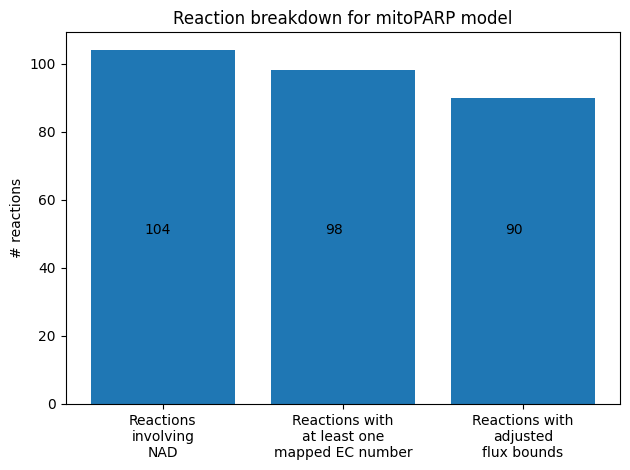

In [12]:
plot = [n_nad_rxns, n_rxns_mapped, n_adjusted]
labels = ['Reactions\ninvolving\nNAD', 'Reactions with\nat least one\nmapped EC number', 'Reactions with\nadjusted\nflux bounds']
pp.bar(height=plot, x=labels)
pp.ylabel('# reactions')
pp.title("Reaction breakdown for mitoPARP model")

pp.annotate(str(n_nad_rxns), (-.1, 50))
pp.annotate(str(n_rxns_mapped), (1.-.1, 50))
pp.annotate(str(n_adjusted), (2.-.1, 50))
pp.tight_layout()

ax = pp.gca()
fig = ax.get_figure()

In [13]:
print('Reactions not mapped to an EC:')
print([r for r in nad_rxns if r not in rxns_mapped])
print('Reactions mapped to an EC for which we found no Km:')
print([r for r in rxns_mapped if r not in adjusted])

Reactions not mapped to an EC:
['AMCOXO', 'AMCOXO2_MitoCore', 'NADHt_MitoCore', 'NADt_MitoCore', 'NADHtm_MitoCore', 'NADtm_MitoCore']
Reactions mapped to an EC for which we found no Km:
['ICDHyrm', 'CI_MitoCore', 'r0645', 'r0178', 'FOLR2', 'DHFR', 'LDH_Dm_MitoCore', 'HOXG']


In [14]:
# 'AMCOXO', 'AMCOXO2_MitoCore' are annotated as EC 1.5.1.-

## Solving models

In [15]:
tags_mito = ['293', 'mitoparp', '293 + low NAD', 'mitoparp + low NAD']
tags_selection = tags_mito + ['subsystem']

In [16]:
sols = {tag: m.optimize() for tag, m in models.items()}
sols_pfba = {tag: cobra.flux_analysis.pfba(m) for tag, m in models.items()}
fva_frac = .80
sols_fva = {tag: cobra.flux_analysis.flux_variability_analysis(m, fraction_of_optimum=fva_frac) for tag, m in models.items()}

In [17]:
sp = {tag: sol.shadow_prices for tag, sol in sols.items()}
fl = {tag: sol.fluxes for tag, sol in sols_pfba.items()}
fl_upper = {tag: sol.maximum for tag, sol in sols_fva.items()}
fl_lower = {tag: sol.minimum for tag, sol in sols_fva.items()}

In [18]:
met_name_map = pd.read_excel(
    mitocore_path / 'CompanionAnnotation_v1.01_1.xlsx', 
    sheet_name='Metabolites',
    engine = 'openpyxl',
    skiprows=2
).iloc[:, range(1,5)].set_index('Model')
met_name_map.head()

,Recon2,KEGG,Name
Model,,,
M_10fthf_c,10fthf,C00234,10-Formyltetrahydrofolate
M_10fthf_m,10fthf,C00234,10-Formyltetrahydrofolate
M_13dpg_c,13dpg,C00236,3-Phospho-D-glyceroyl phosphate
M_1pipdn2c_c,1pipdn2c,C04092,delta1-Piperideine-2-carboxylate
M_1pyr5c_m,1pyr5c,C03912,(S)-1-Pyrroline-5-carboxylate


In [19]:
def get_full_name(tag):
    tag = 'M_' + tag
    name = met_name_map.loc[tag, 'Name']
    ending = tag[-1]
    return name + f' ({ending})'

In [20]:
df_sp = concat(sp, subs=False).loc[:, tags_selection[:-1]]
df_sp['full_name'] = df_sp.index.map(get_full_name)
df_fl = concat(fl).loc[:, tags_selection]
df_fl_upper = concat(fl_upper).loc[:, tags_selection]
df_fl_lower = concat(fl_lower).loc[:, tags_selection]

In [21]:
df_fl.fillna(0.).to_csv(results_path / 'fluxes_pfba.csv')
df_sp.fillna(0.0).to_csv(results_path / "shadow_prices.csv")
df_fl_upper.fillna(0.0).to_csv(results_path / "fluxes_fva_upper.csv")
df_fl_lower.fillna(0.0).to_csv(results_path / "fluxes_fva_lower.csv")

In [22]:
supplements_path = results_path / 'supplements'

df_fl.to_csv(supplements_path / "fluxes_pfba.csv")
df_sp.to_csv(supplements_path / "shadow_prices.csv")
df_fl_upper.to_csv(supplements_path / "fluxes_fva_upper.csv")
df_fl_lower.to_csv(supplements_path / "fluxes_fva_lower.csv")

In [23]:
upper_bounds = {}
lower_bounds = {}
for name, model in models.items():
    upper_bounds[name] = pd.Series({rxn.id: rxn.upper_bound for rxn in model.reactions})
    lower_bounds[name] = pd.Series({rxn.id: rxn.lower_bound for rxn in model.reactions})
upper_bounds = concat(upper_bounds)
lower_bounds = concat(lower_bounds)

In [24]:
lower_bounds.fillna(0.).to_csv(results_path / 'lower_bounds.csv')
upper_bounds.fillna(0.).to_csv(results_path / 'upper_bounds.csv')

In [25]:
lower_bounds.to_csv(supplements_path / "lower_bounds.csv")
upper_bounds.to_csv(supplements_path / "upper_bounds.csv")